In [54]:
using Revise
using CMBLensing
using Statistics
using Setfield
using PyPlot

In [116]:
@unpack f, f̃, ϕ, ds, ds₀, T = load_sim_dataset(
    seed  = 0,
    rfid = 0.1,
    θpix = 3,
    Nside = 64,
    use = :P,
    T = Float32,
    μKarcminT = 1,
)
@unpack Cf, Cϕ = ds₀;

In [ ]:
(rundat,chains) = sample_joint(
    ds,
    θrange = (Aϕ=range(0.5, 1.9, length=25),),
    symp_kwargs = [(N=25, ϵ=0.05)],
    nsamps_per_chain = 100,
    nchains = 1, 
    nburnin_always_accept = Inf,
    progress = :summary
);

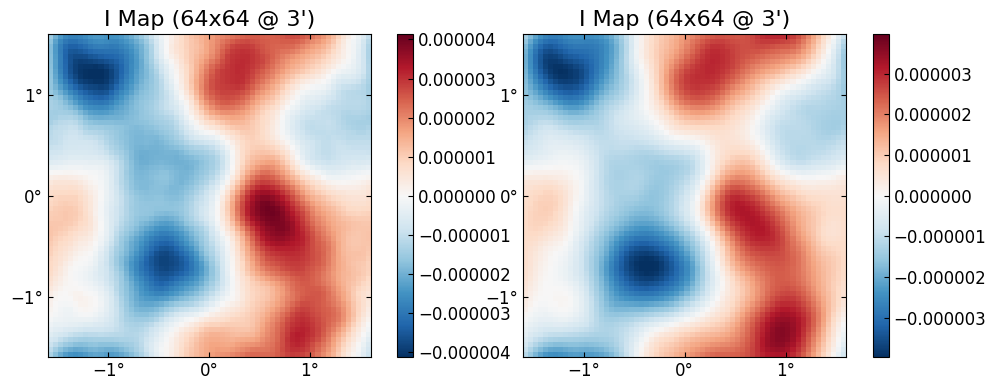

In [39]:
plot([ϕ mean(getindex.(chains[1][2:end],:ϕ))])

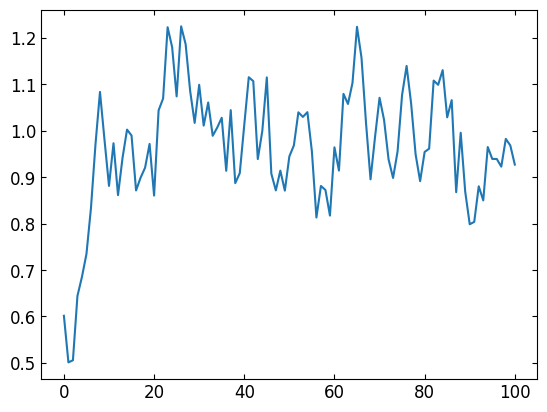

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f165335f6a0>

In [41]:
plot(first.(getindex.(chains[1],:θ)))

In [61]:
using LinearAlgebra

In [126]:
# ds_badG = @set ds.G = ParamDependentOp((;Aϕ=1)->1/√T(Aϕ)*Diagonal(one(ϕ)));
ds_badG = @set ds.G = IdentityOp;

In [183]:
(rundat_badG,chains_badG) = sample_joint(
    ds_badG,
    ϕstart = :quasi_sample,
    θrange = (Aϕ=range(0.5, 1.5, length=25),),
    symp_kwargs = [(N=25, ϵ=0.05)],
    nsamps_per_chain = 100,
    nchains = 1, 
    nburnin_always_accept = Inf,
    progress = :summary
);

Gibbs chain: 100%|██████████████████████████████████████| Time: 0:03:29


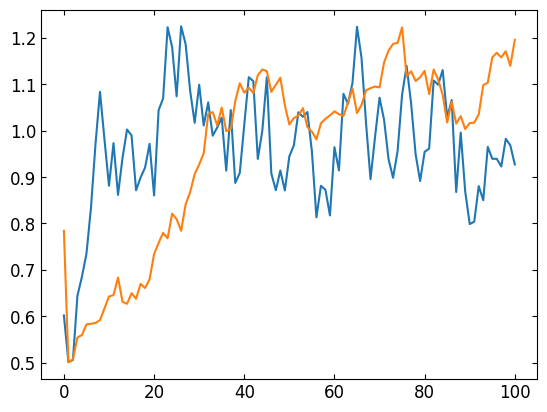

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f16433526d8>

In [184]:
plot(first.(getindex.(chains[1],:θ)))
plot(first.(getindex.(chains_badG[1],:θ)))

In [175]:
@unpack f°,ϕ°,θ = chains_badG[1][end];

In [176]:
Aϕs = range(0.2,1.5,length=50)

0.2:0.026530612244897958:1.5

In [177]:
ilnP,sample,lnPs = CMBLensing.grid_and_sample(θ -> lnP(:mix,f°,ϕ°,θ,ds_badG), (Aϕ=Aϕs,));

In [178]:
sample

(Aϕ = 0.8917985200881957,)

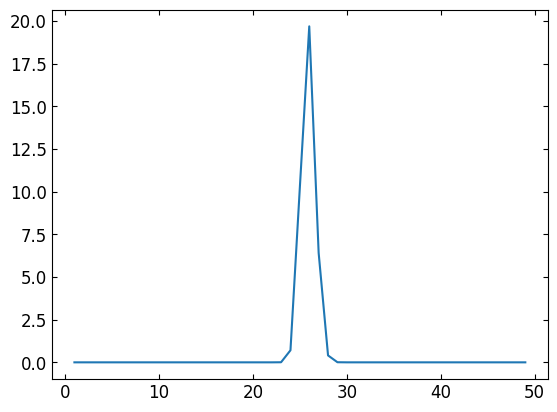

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f16433fb5f8>

In [179]:
plot((exp∘ilnP).(Aϕs))

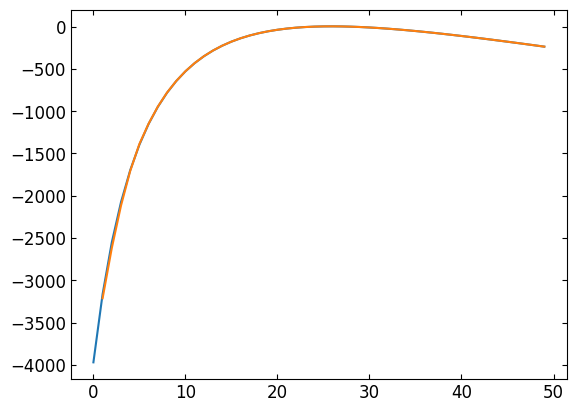

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1650801550>

In [180]:
plot(lnPs)
plot(ilnP.(Aϕs))

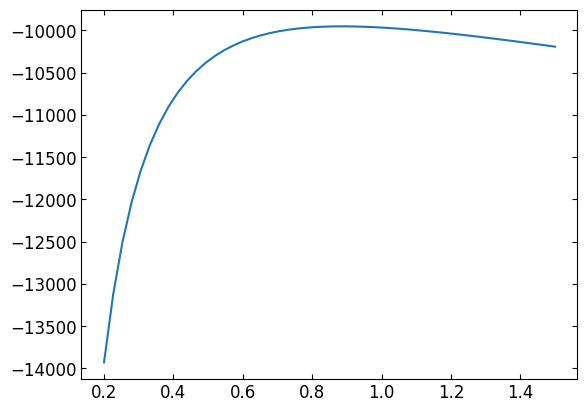

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f16508cce10>

In [181]:
plot(Aϕs,[lnP(:mix,f°,ϕ°,(Aϕ=Aϕ,),ds_badG) for Aϕ in Aϕs])

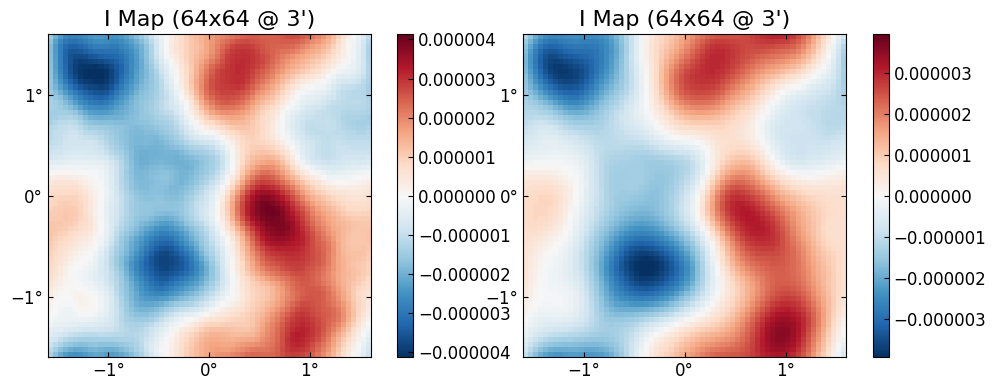

In [47]:
plot([ϕ mean(getindex.(chains_badG[1][2:end],:ϕ))])